# Time series forecasting example
In this example we will look at forecasting future temperature from historic weather data.
The data is obtained from: https://www.southamptonweather.co.uk/wxtempsummary.php

In [1]:
# Load the required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import xlsxwriter as xlw
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Next, we'll load the file that has been formatted with the data and set up some custom parameters

In [2]:
# setup
file_name = 'C:\\Users\\kelvi\\Desktop\\southampton_wxr.xlsx' # train/test on existing data

#filter configurations
val_num = 10 # train/test split on number x e.g 10 rows into data
future_time = 12 # days,years,months etc predictions
data_adj = 'sqrt' # can be normal, log, sqrt - to adjust y-values
n_lags = 10 # for determining autocorrelation and partial auto correlation reference points

################################# load file #######################################
if data_adj not in ['normal','log','sqrt']:
    raise ValueError('You must select data_adj as one of: normal, log or sqrt') 

#open file
df = pd.read_excel(file_name)#, skiprows=4,sheet_name='test')

#rename col of interest to 'test'
df.rename(columns={'temp':'test'},inplace=True) # here we are looking at / predicting temp (or temperature)

Next we'll convert the date data to tmime-series and set some mean and standard deviation parameters

In [3]:
df['year'] = pd.to_datetime(df['date'])

df['roll_mean'] = df['test'].rolling(window=12).mean()
df['std'] = df['test'].rolling(window=12).std()

Here we'll make a train/test dataset

In [4]:
#define test and train data note that as time dependent test data should be in the future
val_num=str(val_num)
train = df[df['year'] <= '2018'+'-01-01'] # train on data before or equal to 1st January 2018
test = df[df['year'] > '2018'+'-01-01'] # test on data after 1st January 2018

Now we will do some parameter adjustments and plot some graphs to get the p and d values of the (p,d,q) values of the time-series forecasting models

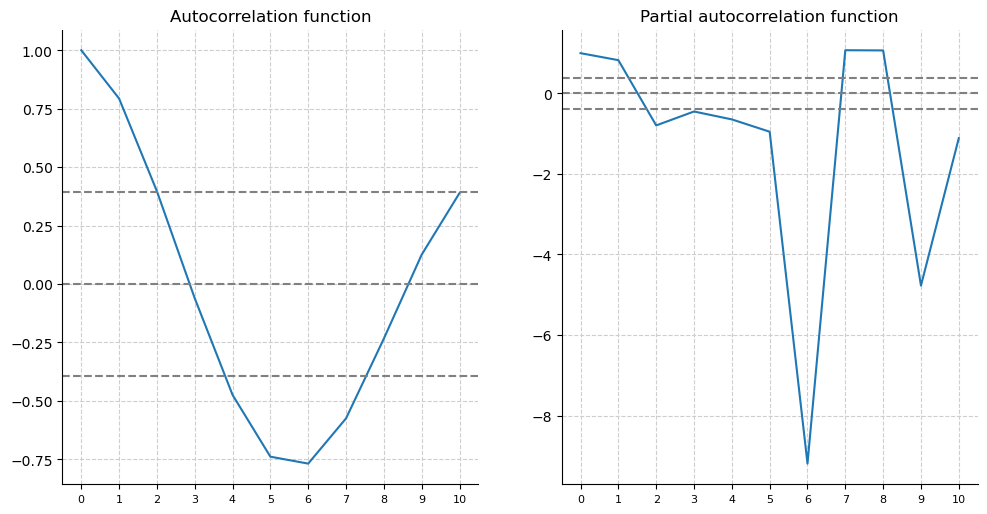

In [5]:
################ model configuration #####################
if data_adj == 'normal':
    y = (train['test'].astype(int))
    y1 = (df['test'].astype(int))
elif data_adj == 'log':
    y = np.log(train['test'].astype(int))
    y1 = np.log(df['test'].astype(int))
elif data_adj == 'sqrt':
    y = np.sqrt(train['test'].astype(int))
    y1 = np.sqrt(df['test'].astype(int))
    
    
acfer = acf(y,nlags=n_lags) # auto correlation
pacfer = pacf(y,nlags=n_lags) # partial auto correlation

# plot acfer
fig, (ax, ax1) = plt.subplots(1,2)
ax.plot(acfer)
ax.axhline(y=0, linestyle='dashed',color='gray')
ax.axhline(y=-1.96/np.sqrt(len(y)),linestyle='dashed',color='gray')
ax.axhline(y=1.96/np.sqrt(len(y)),linestyle='dashed',color='gray')
ax.grid(linestyle='--',color='#CECECE')
ax.set_title('Autocorrelation function')
ax.set_xticks(range(0,n_lags+1,1))    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(range(0,n_lags+1,1), rotation='horizontal',size=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot pacfer
ax1.plot(pacfer)
ax1.axhline(y=0, linestyle='dashed',color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(y)),linestyle='dashed',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(y)),linestyle='dashed',color='gray')
ax1.grid(linestyle='--',color='#CECECE')
ax1.set_title('Partial autocorrelation function')
ax1.set_xticks(range(0,n_lags+1,1))    # This ensures we have one tick per year, otherwise we get fewer
ax1.set_xticklabels(range(0,n_lags+1,1), rotation='horizontal',size=8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#set size of graph
cmsize=1/2.54
fig.set_size_inches(30*cmsize, 15*cmsize)

From the graph we can see that '2' is the best value to use, (1.2 rounded up) (where the right hand graph first crosses the confidence interval line) for p and for q it is also '2' (where the left hand graph first crosses the confidence interval line)

Below, we will perform a Dickey-Fuller test (a statistical test to check if our values are stationary)

In [6]:
# perform dickey-fuller test
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


# store results as df:
dff_output = pd.DataFrame(dfoutput)
dff_output.rename(columns={0:'values'},inplace=True)
dff_output['names']=dff_output.index
dff_output = dff_output[['names','values']]

Results of Dickey-Fuller Test:
Test Statistic                 -3.518336
p-value                         0.007528
#Lags Used                      6.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


From these results we can see that our data is stationary, so we can go ahead and model it using our pre-determined parameters. Note that it is stationary because the test statistics is less than the critical value(s). The critical values reflect how confident we cna be that our value(s) are stationary. e.g. a figure less than the critical value (5%) means we are over 95% confident our values are stationary. A value lower than the 1% critical value means we are over 99% confident the values are stationary.

Next we'll add in the models and model parameters as determined earlier, although these can be adjusted manually to see the difference in predictions

In [7]:
ARMAmodel = SARIMAX(y, order = (2, 0, 2))
ARIMAmodel = ARIMA(y, order = (2, 1, 2))
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))

ARMAmodeltest = SARIMAX(y1, order = (2, 0, 2))
ARIMAmodeltest = ARIMA(y1, order = (2, 1, 2))
SARIMAXmodeltest = SARIMAX(y1, order = (5, 4, 2), seasonal_order=(2,2,2,12))

We will create some functions below for ease of use - graphs and data adjustments

In [8]:
def lwrtest(value):
    if value < 0:
        return 0
    elif data_adj == 'log':
        return np.exp(value)
    elif data_adj == 'normal':
        return value
    elif data_adj == 'sqrt':
        return value**2

def lower_test():
    test1['lower test'] = test1['lower test'].apply(lwrtest)#,axis=1)
    test1['Predictions'] = test1['Predictions'].apply(lwrtest)#,axis=1)
    test1['upper test'] = test1['upper test'].apply(lwrtest)#,axis=1)
    
def lower_test_predict():
    df1['lower test'] = df1['lower test'].apply(lwrtest)#,axis=1)
    df1['Predictions'] = df1['Predictions'].apply(lwrtest)#,axis=1)
    df1['upper test'] = df1['upper test'].apply(lwrtest)#,axis=1)
    
############################ graph definitions #########################################
def testdatalinegraph(title):
    # Initialise a figure. subplots() with no args gives one plot.
    fig, ax = plt.subplots()


    ax.plot(range(0,len(test1.index),1), test1['test'], label='Real', color='#CD2456')
    ax.plot(range(0,len(test1.index),1), test1['roll_mean'], label='Mean', color='#CD2456', linestyle='dashed')
    ax.plot(range(0,len(test1.index),1), test1['std'], label='std', color='#CD2456', linestyle='dotted')
    ax.plot(range(0,len(test1.index),1), test1['Predictions'], label='Predicted', color='#14022E')
    ax.fill_between(range(0,len(test1.index),1),(test1['Predictions']-(test1['Predictions']-test1['lower test'])),(test1['Predictions']+(test1['upper test']-test1['Predictions'])),alpha=0.2)

    # Customise some display properties for line graph
    ax.set_ylabel('',size=8)
    #ax.set_ylim(0,200)
    #ax.set_xlim(0,8)
    ax.set_xlabel('',size=8)
    ax.set_title(title,size=9)
    ax.set_xticks(range(0,len(test1.index),1))    # This ensures we have one tick per year, otherwise we get fewer
    ax.set_xticklabels(range(0,len(test1.index),1), rotation='horizontal',size=8)
    #ax.fill(df.Doy[df.Product=='A'],df.Sales[df.Product=='A']-5,df.Sales[df.Product=='A']+5,color='k', alpha=.15)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.legend(loc='upper left',fontsize=8)
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)

    
def futurelinegraph(title):
    # Initialise a figure. subplots() with no args gives one plot.
    fig, ax = plt.subplots()

    ax.plot(range(0,len(df1.index),1), df1['test'], label='Real', color='#CD2456')
    ax.plot(range(0,len(df1.index),1), df1['roll_mean'], label='Mean', color='#CD2456',linestyle='dashed')
    ax.plot(range(0,len(df1.index),1), df1['std'], label='std', color='#CD2456', linestyle='dotted')
    ax.plot(range(0,len(df1.index),1), df1['Predictions'], label='Predicted', color='#14022E')
    ax.fill_between(range(0,len(df1.index),1),(df1['Predictions']-(df1['Predictions']-df1['lower test'])),(df1['Predictions']+(df1['upper test']-df1['Predictions'])),alpha=0.2)

    # Customise some display properties for line graph
    ax.set_ylabel('',size=8)
    #ax.set_ylim(0,200)
    #ax.set_xlim(0,8)
    ax.set_xlabel('',size=8)
    ax.set_title(title,size=9)
    ax.set_xticks(range(0,len(df1.index),1))    # This ensures we have one tick per year, otherwise we get fewer
    ax.set_xticklabels(range(0,len(df1.index),1), rotation='horizontal',size=8)
    #ax.fill(df.Doy[df.Product=='A'],df.Sales[df.Product=='A']-5,df.Sales[df.Product=='A']+5,color='k', alpha=.15)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.legend(loc='upper left',fontsize=8)
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)

We'll test the data for an ARIMA model

RMSE:  18.76034816422122


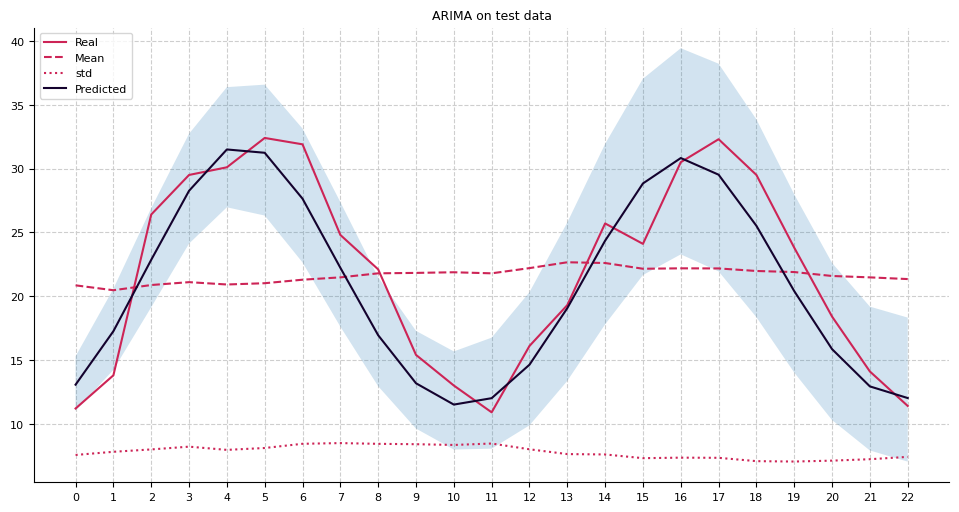

In [9]:
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df['rmse'] =  np.sqrt(mean_squared_error(test["test"], y_pred_df["Predictions"]))
y_pred_df['accuracy'] = (y_pred_df["Predictions"]/test["test"])
y_pred_df['mae']=mean_absolute_error(test["test"].values, y_pred_df["Predictions"])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

#append to test data
test1 = pd.merge(test,y_pred_df,how="left",on=test.index)

lower_test() # data adjustment

################### line graph ###############################################
testdatalinegraph(title="ARIMA on test data")

import numpy as np
from sklearn.metrics import mean_squared_error

arima_rmse = np.sqrt(mean_squared_error(test["test"].values, y_pred_df["Predictions"]))
print("RMSE: ",arima_rmse)

Here we can see that the model roughly follows the real data, which is reassuring! The light blue fill shows the error values (range between upper and lower predictions) of the predictions from the model

Finally, we'll use this model and predict future values

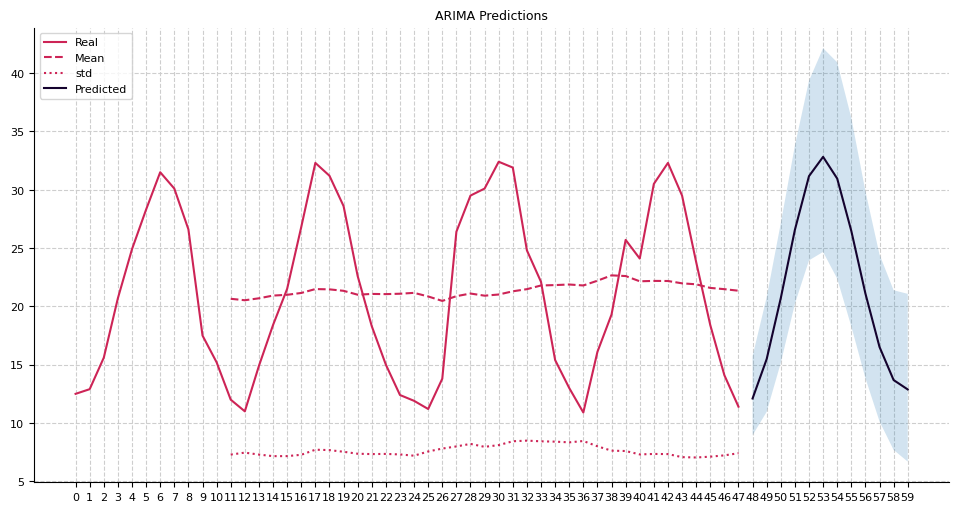

In [10]:
################################# future predictions ##################################
df['Predictions']=np.nan
############### arima ####################################
##########################################################
ARIMAmodeltest = ARIMAmodeltest.fit()

y_pred = ARIMAmodeltest.get_forecast((len(df.index)+future_time)-len(df.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodeltest.predict(start = y_pred_df.index[0], end = y_pred_df.index[0]+future_time)
#y_pred_df.index = (df.index+future_time)
y_pred_out = y_pred_df["Predictions"] 

#join onto original data
df1=pd.concat([df,y_pred_df])
df1['roll_mean'] = df1['test'].rolling(window=12).mean()
df1['std'] = df1['test'].rolling(window=12).std()
lower_test_predict()

#graph this
################### line graph ###############################################
futurelinegraph(title="ARIMA Predictions")

We can see the future 12 months of predictions from the model. As the prediction moves further ahead, the uncertainty of the model (blue fill) increases in size.